<a href="https://colab.research.google.com/github/Rasa16/Face_recognition/blob/master/face_recognise_own_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import the necessary packages
import numpy as np
import argparse
import imutils
import pickle
import cv2
import os

In [ ]:
# load our serialized face detector from disk
print("[INFO] loading face detector...")
protoPath = os.path.sep.join(["/content/drive/My Drive/Face_recognition_own/face_recognition_own_opencv/opencv-face-recognition/face_detection_model/", "deploy.prototxt"])
modelPath = os.path.sep.join(["/content/drive/My Drive/Face_recognition_own/face_recognition_own_opencv/opencv-face-recognition/face_detection_model/",
	"res10_300x300_ssd_iter_140000.caffemodel"])
detector = cv2.dnn.readNetFromCaffe(protoPath, modelPath)

# load our serialized face embedding model from disk
print("[INFO] loading face recognizer...")
embedder = cv2.dnn.readNetFromTorch("/content/drive/My Drive/Face_recognition_own/face_recognition_own_opencv/opencv-face-recognition/openface_nn4.small2.v1.t7")

# load the actual face recognition model along with the label encoder
recognizer = pickle.loads(open("/content/drive/My Drive/Face_recognition_own/face_recognition_own_opencv/model.pickle", "rb").read())
le = pickle.loads(open("/content/drive/My Drive/Face_recognition_own/face_recognition_own_opencv/label_encoder.pickle", "rb").read())

[INFO] loading face detector...
[INFO] loading face recognizer...


In [ ]:
# load the image, resize it to have a width of 600 pixels (while
# maintaining the aspect ratio), and then grab the image dimensions
image = cv2.imread("/content/drive/My Drive/Face_recognition_own/Testing_pics/IMG_20181223_200430.jpg")
image = imutils.resize(image, width=600)
(h, w) = image.shape[:2]

# construct a blob from the image
imageBlob = cv2.dnn.blobFromImage(
	cv2.resize(image, (300, 300)), 1.0, (300, 300),
	(104.0, 177.0, 123.0), swapRB=False, crop=False)

# apply OpenCV's deep learning-based face detector to localize
# faces in the input image
detector.setInput(imageBlob)
detections = detector.forward()

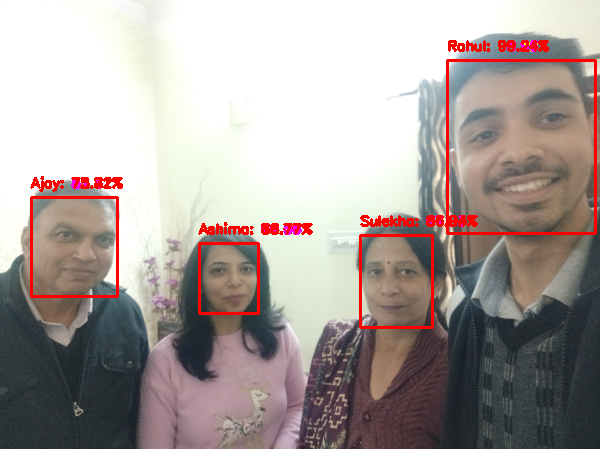

-1

In [ ]:
# loop over the detections
for i in range(0, detections.shape[2]):
	# extract the confidence (i.e., probability) associated with the
	# prediction
	confidence = detections[0, 0, i, 2]

	# filter out weak detections
	if confidence > 0.5:
		# compute the (x, y)-coordinates of the bounding box for the
		# face
		box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
		(startX, startY, endX, endY) = box.astype("int")

		# extract the face ROI
		face = image[startY:endY, startX:endX]
		(fH, fW) = face.shape[:2]

		# ensure the face width and height are sufficiently large
		if fW < 20 or fH < 20:
			continue

		# construct a blob for the face ROI, then pass the blob
		# through our face embedding model to obtain the 128-d
		# quantification of the face
		faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255, (96, 96),
			(0, 0, 0), swapRB=True, crop=False)
		embedder.setInput(faceBlob)
		vec = embedder.forward()

		# perform classification to recognize the face
		preds = recognizer.predict_proba(vec)[0]
		j = np.argmax(preds)
		proba = preds[j]
		name = le.classes_[j]

		# draw the bounding box of the face along with the associated
		# probability
		text = "{}: {:.2f}%".format(name, proba * 100)
		y = startY - 10 if startY - 10 > 10 else startY + 10
		cv2.rectangle(image, (startX, startY), (endX, endY),
			(0, 0, 255), 2)
		cv2.putText(image, text, (startX, y),
			cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

# show the output image
from google.colab.patches import cv2_imshow
cv2_imshow(image)
cv2.waitKey(0)